# Detecção de Fraude

A base de dados qua será usadas paras as analises e modelagem faz parte de de um conjunto de dados do Kaggle chamada [Fraud Detection Example](https://www.kaggle.com/gopalmahadevan/fraud-detection-example) e ela tem uma fração de dados do [PaySim](https://github.com/EdgarLopezPhD/PaySim), um simulador de dados financeiros feito exatamente para detecção de fraude.


## Referencias

Os aprendizados aplicados nesse projeto fazem parte de um dos curso ministrados pela [Sthefanie Monica Premebida](https://www.linkedin.com/in/sthefanie-monica/) junto a [Alura](https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude).


## Conjunto de dados

**Variáveis do dataset**

* **step** - mapeia uma unidade de tempo no mundo real. Neste caso, 1 passo é 1 hora de tempo. Total de etapas 744 (simulação de 30 dias).

* **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER. 
(caixa-de-entrada, caixa-de-saida, débito, pagamento e transferência)

* **amount** - valor da transação em moeda local.

* **nameOrig** - cliente que iniciou a transação

* **oldbalanceOrg** - saldo inicial antes da transação

* **newbalanceOrig** - novo saldo após a transação

* **nameDest** - cliente que é o destinatário da transação

* **oldbalanceDest** - destinatário do saldo inicial antes da transação. 
Observe que não há informações para clientes que começam com M (Comerciantes).

* **newbalanceDest** - novo destinatário do saldo após a transação. Observe que não há informações para clientes que começam com M (Comerciantes).

* **isFraud** - São as transações feitas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar ao assumir o controle das contas dos clientes e tentar esvaziar os fundos transferindo para outra conta e depois sacando do sistema.

* **isFlaggedFraud** - O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinaliza tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.


**OBS: Como o objetivo deste projeto é usar ML para detecção de fraude, não foquei em fazer um analise exploratoria manual. optei por usar o `Pandas Profiling`para fazer as analises de variáveis.**


# Bibliotecas

In [61]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV

# Importando dados

In [2]:
df = pd.read_csv(r"../data/fraud_dataset_example.csv")

In [3]:
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

# Analises iniciais

## Renomeando as colunas

In [4]:
colunas = {
    'isFraud': 'fraude',
    'isFlaggedFraud':'super_fraude',
    'step':'tempo',
    'type':'tipo',
    'amount':'valor',
    'nameOrig':'cliente1',
    'oldbalanceOrg':'saldo_inicial_c1',
    'newbalanceOrig':'novo_saldo_c1',
    'nameDest':'cliente2',
    'oldbalanceDest':'saldo_inicial_c2',
    'newbalanceDest':'novo_saldo_c2',
}

df.rename( columns= colunas, inplace= True)

df.head()

tempo      tipo     valor     cliente1  saldo_inicial_c1  novo_saldo_c1  \
0      1   PAYMENT   9839.64  C1231006815          170136.0      160296.36   
1      1   PAYMENT   1864.28  C1666544295           21249.0       19384.72   
2      1  TRANSFER    181.00  C1305486145             181.0           0.00   
3      1  CASH_OUT    181.00   C840083671             181.0           0.00   
4      1   PAYMENT  11668.14  C2048537720           41554.0       29885.86   

      cliente2  saldo_inicial_c2  novo_saldo_c2  fraude  super_fraude  
0  M1979787155               0.0            0.0       0             0  
1  M2044282225               0.0            0.0       0             0  
2   C553264065               0.0            0.0       1             0  
3    C38997010           21182.0            0.0       1             0  
4  M1230701703               0.0            0.0       0             0

## Outras informações do dataset

In [5]:
df.describe()

tempo         valor  saldo_inicial_c1  novo_saldo_c1  \
count  101613.000000  1.016130e+05      1.016130e+05   1.016130e+05   
mean        8.523457  1.740901e+05      9.071753e+05   9.234992e+05   
std         1.820681  3.450199e+05      2.829575e+06   2.867319e+06   
min         1.000000  3.200000e-01      0.000000e+00   0.000000e+00   
25%         8.000000  1.001659e+04      0.000000e+00   0.000000e+00   
50%         9.000000  5.338541e+04      2.019047e+04   0.000000e+00   
75%        10.000000  2.124984e+05      1.947150e+05   2.192178e+05   
max        10.000000  1.000000e+07      3.893942e+07   3.894623e+07   

       saldo_inicial_c2  novo_saldo_c2         fraude  super_fraude  
count      1.016130e+05   1.016130e+05  101613.000000      101613.0  
mean       8.810428e+05   1.183998e+06       0.001142           0.0  
std        2.399949e+06   2.797761e+06       0.033768           0.0  
min        0.000000e+00   0.000000e+00       0.000000           0.0  
25%        0.000000e+00   0.000000e+00       0.000000           0.0  
50%        2.105800e+04   5.178343e+04       0.000000           0.0  
75%        5.919217e+05   1.063122e+06       0.000000           0.0  
max        3.400874e+07   3.894623e+07       1.000000           0.0

O método describe() fornece as informações sobre:

**count** - Conta a quantidade de número de valores não vazios. Com esses valores podemos entender melhor o tamanho da amostra.

**mean** - O valor médio, em média aritmética. Como ele faz uma média aritmética nem sempre mostra a realidade da maior parte dos casos do banco de dados.

**std** - O desvio padrão. É a medida de como os dados se dispersam em relação à média, ou seja, o quanto eles estão espalhados.

**min** e **max** - Valores que auxiliam a identificar a amplitude da amostra, entre o valor mínimo e máximo.

**quartis** - Valores que nos mostram de que forma os dados foram distribuídos, por exemplo em 50% é a mediana e metade dos valores são inferiores a X valor, a outra metade é superior àquele valor.

Para saber mais sobre esse método, acesse o artigo [Ampliando a análise com o Describe](https://www.alura.com.br/artigos/ampliando-a-analise-com-describe).


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tempo             101613 non-null  int64  
 1   tipo              101613 non-null  object 
 2   valor             101613 non-null  float64
 3   cliente1          101613 non-null  object 
 4   saldo_inicial_c1  101613 non-null  float64
 5   novo_saldo_c1     101613 non-null  float64
 6   cliente2          101613 non-null  object 
 7   saldo_inicial_c2  101613 non-null  float64
 8   novo_saldo_c2     101613 non-null  float64
 9   fraude            101613 non-null  int64  
 10  super_fraude      101613 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB


In [7]:
print('{} Linhas e {} colunas'.format(df.shape[0], df.shape[1]))
print('Quantidade de dados nulos:', df.isna().sum().sum())

101613 Linhas e 11 colunas
Quantidade de dados nulos: 0


## Verificando a variável target

In [8]:
df.groupby('fraude')[['tempo']].count()

tempo
fraude        
0       101497
1          116

Aqui já podemos ver que as nossas classes estão desbalanceadas. Mas iremos seguir com as analises dos modelos e diante dos resultados poder fazer o tratamentos das classes.

## Encoding

### Pandas Profiling

In [9]:
profile = pandas_profiling.ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("EDA Profiling Report.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Aplicando o Encoding

#### Tipos de encoding

**Label Encoding** - Renomea as classes com valores numéricos de 1 a **n**, sendo n o número de classes. Pode existir hierarquia entre as classes.

**One-Hot Encoding** - Transforma as variáveis em **n** colunas binárias, sendo n o número de classes. Todas as classes são analisadas de forma igual, quando tiver a ocorrência dela a coluna terá o valor 1 e quando não o valor 0, isso acontece para as demais colunas criadas.



In [10]:
df = pd.get_dummies(data= df, columns=['tipo'])

In [11]:
df.head()

tempo     valor     cliente1  saldo_inicial_c1  novo_saldo_c1     cliente2  \
0      1   9839.64  C1231006815          170136.0      160296.36  M1979787155   
1      1   1864.28  C1666544295           21249.0       19384.72  M2044282225   
2      1    181.00  C1305486145             181.0           0.00   C553264065   
3      1    181.00   C840083671             181.0           0.00    C38997010   
4      1  11668.14  C2048537720           41554.0       29885.86  M1230701703   

   saldo_inicial_c2  novo_saldo_c2  fraude  super_fraude  tipo_CASH_IN  \
0               0.0            0.0       0             0             0   
1               0.0            0.0       0             0             0   
2               0.0            0.0       1             0             0   
3           21182.0            0.0       1             0             0   
4               0.0            0.0       0             0             0   

   tipo_CASH_OUT  tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0              0           0             1              0  
1              0           0             1              0  
2              0           0             0              1  
3              1           0             0              0  
4              0           0             1              0

#### Removendo variáveis

Verificado na analise feita acima, a variável 'super_fraude' não contém apenas valores 0, por conta de não ter tido nenhuma "super fraude". E as variáveis conténdo o nome dos clientes não será ultilizada. **Diante disso, essas colunas seram removidas**.

In [12]:
df = df.drop(['cliente1', 'cliente2', 'super_fraude'], axis = 1)

In [13]:
df.head()

tempo     valor  saldo_inicial_c1  novo_saldo_c1  saldo_inicial_c2  \
0      1   9839.64          170136.0      160296.36               0.0   
1      1   1864.28           21249.0       19384.72               0.0   
2      1    181.00             181.0           0.00               0.0   
3      1    181.00             181.0           0.00           21182.0   
4      1  11668.14           41554.0       29885.86               0.0   

   novo_saldo_c2  fraude  tipo_CASH_IN  tipo_CASH_OUT  tipo_DEBIT  \
0            0.0       0             0              0           0   
1            0.0       0             0              0           0   
2            0.0       1             0              0           0   
3            0.0       1             0              1           0   
4            0.0       0             0              0           0   

   tipo_PAYMENT  tipo_TRANSFER  
0             1              0  
1             1              0  
2             0              1  
3             0              0  
4             1              0

# Escolhendo Modelos

## Separando variáveis preditoras e target

Antes de criar o modelo, irei definir quais colunas são  "características" e qual coluna queremos prever.

Ou seja, vamos definir as colunas de features (X) e targets (y)

Features (Aspectos) x Target (Alvo)

In [14]:
X = df.drop(['fraude'],axis=1)
Y = df['fraude']

SEED = 42

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state=SEED)

## Regressão Logística

In [15]:
lr = LogisticRegression(max_iter=1000, random_state=SEED)
lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9989765391276965
Precisão: 0.2
Recall: 0.043478260869565216
F1: 0.07142857142857142


Supreendentemente, a acurácia ficou bem alta: `0.99`. ´De certo modo isso muito bom! Significa que o nosso modelo, em termos gerais, está acertando bastante. Porém, as nossas outras métricas estão um pouco baixas. A precisão, que é a métrica que avalia a quantidade de verdadeiros positivos, ou seja, quantas vezes a fraude está acertando, está baixa: `0.2`.

O Recall diz respeito à nossa sensibilidade, à nossa reevocação. Ele avalia a capacidade do modelo classificar corretamente as classes, sejam elas fraudes ou não, 0 ou 1. Se temos um valor de `0.4`, quer dizer que não estamos acertando tão bem.

O f1_score, que é a média harmônica entre a nossa precisão e o nosso recall. Um ponto interessante é que quando temos uma acurácia muito alta e um F1 muito baixo, é sinal de que, talvez, a nossa acurácia não seja tão confiável. Por outro lado, se temos uma acurácia alta e um f1_score alto, significa que o nosso resultado é relevante.

**Acurácia (accuracy)**: Métrica utilizada para visualizar de forma geral o desempenho do classificador.
- Fornece o percentual de classificações corretas pelo classificador.

**OBS: Apresenta problemas com classes desbalanceadas.**

**Precisão (Precision)**: Fornece o número de vezes que uma determinada classe foi predita corretamente dividindo pelo número de vezes que a classe foi predita.

É uma métrica que avalia a quantidade de verdadeiros positivos sobre a soma de todos os valores positivos.

**Revogação (também conhecida como `recall` ou sensibilidade)**: Fornece o número de vezes que uma determinada classe foi predita corretamente dividido pelo numero de classe que contém no dados.

**F-score (F–measure, F-score ou score F1)**: É uma média harmônica calculada com base na precisão e na revocação.

In [16]:
cm = confusion_matrix(y_test, y_pred)

mat_con = ConfusionMatrixDisplay(confusion_matrix=cm)
mat_con.plot()
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

Do lado esquerdo, os valores marcados com zero seriam os nossos verdadeiros negativos, são as partes que não são fraudes e estão acertando muito, porém, o verdadeiro positivo acertou apenas uma vez. Algo diferente, portanto, está acontecendo: ele está acertando muito em uma classe e pouco em outra. Os outros valores estão bem baixos.

Isso pode está acontecendo por conta das classes estarem desbalanceadas.

Mas antes de confirmar essa informação, irei avaliar o modelo com outras métrica `Curva Roc`.

In [17]:
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (8, 5)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=0)
plt.tight_layout()

Na Curva Roc, quanto mais perto de 1 fica a curva azul fica, melhor ela é. Quanto mais rápido ela chega no valor 1 do eixo y, melhor. É possível notar que a subida da curva azul está um pouco estranha, quadrada. Até (0.2, 1.0) ela ainda está tentando se estabilizar, a partir desse ponto ela se estabiliza e chega até o ponto de estabilização que é o 1, ao final.

Mas, ela está com uma curva de AUC boa, com valor de `0.958`. A nossa acurácia está boa, mas as nossas outras métricas, não. Provavelmente isso está acontecendo, porque as nossas classes estão realmente desbalanceadas, o que atrapalha os nossos modelos e o trabalho com as classes.

## Balanceamento de dados

Existem dois tipos possíveis de balanceamento de dados: o `undersampling` e o `oversampling`. 

A primeira opção, undersampling, reduz todos os dados da nossa opção majoritária, isto é, de não fraude, para 116 dados, o que não faz tanto sentido no nosso caso, considerando que já não temos muitos dados de fraude e não teríamos tantos dados para treinamento. Seria complicado continuar fazendo as nossas análises e elas não trariam uma boa acurácia.

A segunda opção, oversampling, é basicamente duplicar, fazer a cópia dos nossos dados da classe minoritária até chegar no valor da classe majoritária. Então, ela faria cópia dos dados de fraude, ou seja, criaria novos dados até chegarmos ao número de dados de não fraude.

Também existem outras formas de driblarmos essa criação aleatória de dados. Uma delas é a técnica Smote, que utiliza KNN (K Nearest Neighbor).

O KNN pega os 116 valores de fraude e acha os vizinhos. Então, aleatoriamente pegará um valor, por exemplo, o 5 e o 20 e vai dizer "esses valores têm determinado tipo e eu vou criar um novo valor". Agora esse novo valor vai entrar também na nova contagem. Ele continuará assim, encontrando os novos valores até chegar no valor total que precisamos: a nossa classe majoritária, ou seja, de não fraude.

In [18]:
SEED=42
smote = SMOTE(random_state=42)

x = df.drop('fraude', axis=1)
y = df['fraude']

x_resampled, y_resampled = smote.fit_resample(x,y)

df_balanced = pd.concat([y_resampled, x_resampled], axis=1)
df_balanced

fraude  tempo          valor  saldo_inicial_c1  novo_saldo_c1  \
0            0      1    9839.640000     170136.000000      160296.36   
1            0      1    1864.280000      21249.000000       19384.72   
2            1      1     181.000000        181.000000           0.00   
3            1      1     181.000000        181.000000           0.00   
4            0      1   11668.140000      41554.000000       29885.86   
...        ...    ...            ...               ...            ...   
202989       1      5   17608.962863      17608.962863           0.00   
202990       1      7   12116.291013      12116.291013           0.00   
202991       1      1  231612.880715     231612.880715           0.00   
202992       1      9  547325.144758     547325.144758           0.00   
202993       1      4  159298.594420     159298.594420           0.00   

        saldo_inicial_c2  novo_saldo_c2  tipo_CASH_IN  tipo_CASH_OUT  \
0               0.000000       0.000000             0              0   
1               0.000000       0.000000             0              0   
2               0.000000       0.000000             0              0   
3           21182.000000       0.000000             0              1   
4               0.000000       0.000000             0              0   
...                  ...            ...           ...            ...   
202989          0.000000       0.000000             0              0   
202990          0.000000       0.000000             0              0   
202991       1945.589357    9370.603471             0              0   
202992          0.000000       0.000000             0              0   
202993          0.000000       0.000000             0              0   

        tipo_DEBIT  tipo_PAYMENT  tipo_TRANSFER  
0                0             1              0  
1                0             1              0  
2                0             0              1  
3                0             0              0  
4                0             1              0  
...            ...           ...            ...  
202989           0             0              1  
202990           0             0              1  
202991           0             0              0  
202992           0             0              1  
202993           0             0              1  

[202994 rows x 12 columns]

In [19]:
df_balanced.groupby('fraude')[['tempo']].count()

tempo
fraude        
0       101497
1       101497

In [20]:
x = df_balanced.iloc[:, 1:].values
y = df_balanced.iloc[:, 0].values

In [21]:
from sklearn.model_selection import train_test_split

SEED = 42

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = SEED)

from sklearn.linear_model import LogisticRegression
from sklearn import metrics

lr = LogisticRegression(max_iter=1000, random_state=SEED)

lr.fit(x_train, y_train)
y_pred =lr.predict(x_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9417722516699837
Precisão: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975


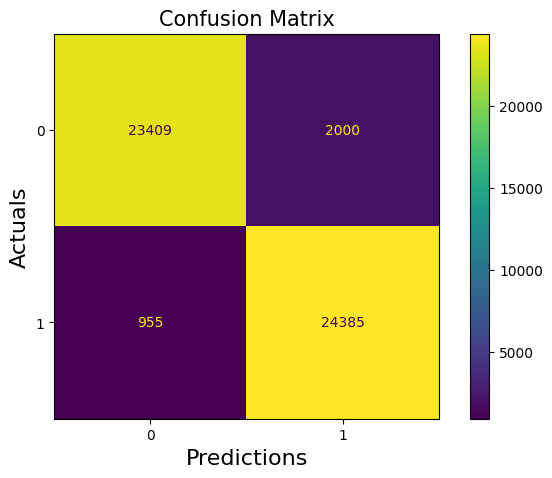

In [22]:
cm = confusion_matrix(y_test, y_pred)

mat_con = ConfusionMatrixDisplay(confusion_matrix=cm)
mat_con.plot()
plt.xlabel('Predictions', fontsize=16)
plt.ylabel('Actuals', fontsize=16)
plt.title('Confusion Matrix', fontsize=15)
plt.show()

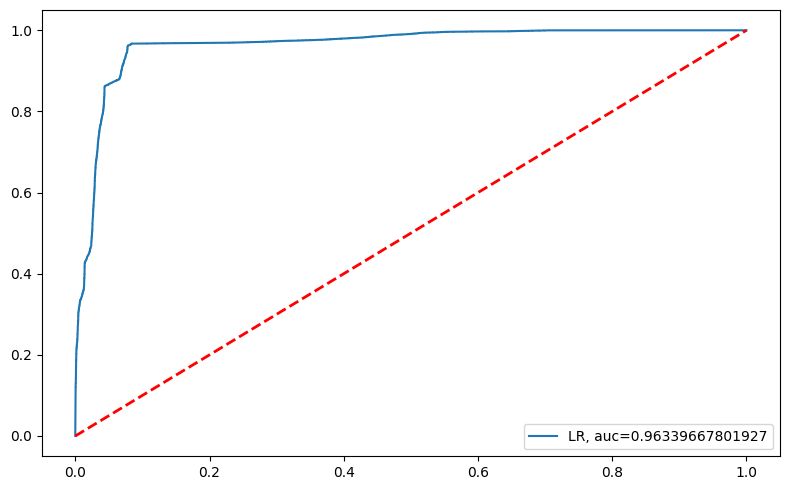

In [23]:
y_pred_proba = lr.predict_proba(x_test)[::, 1]
fpr, tpr, _= metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (8, 5)
plt.plot(fpr,tpr,label="LR, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=0)
plt.tight_layout()

### Formulando as hipóteses

In [24]:
profile = pandas_profiling.ProfileReport(df_balanced, title="Pandas Profiling Report df balanced")
profile.to_file("df_balanced_EDA Profiling Report.html")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

tipo_PAYMENT é o que a pessoa utiliza como padrão e a fraude ocorre por meio do tipo_TRANSFER

O cliente pode fazer seus pagamentos durante um período do dia, como por exemplo durante a manhã, e a fraude ocorre durante um período diferente, como a madrugada.

O cliente paga as duas contas no começo do mês e houve uma movimentação no final do mês, sendo uma fraude.

 ## Random Forest

Random Forest.drawio.png

In [25]:
rf = RandomForestClassifier(max_depth= 5, random_state = SEED)

In [26]:
model = rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9723738398786183
Precisão: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


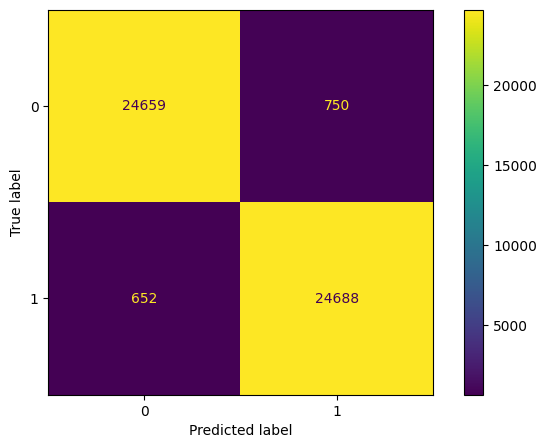

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

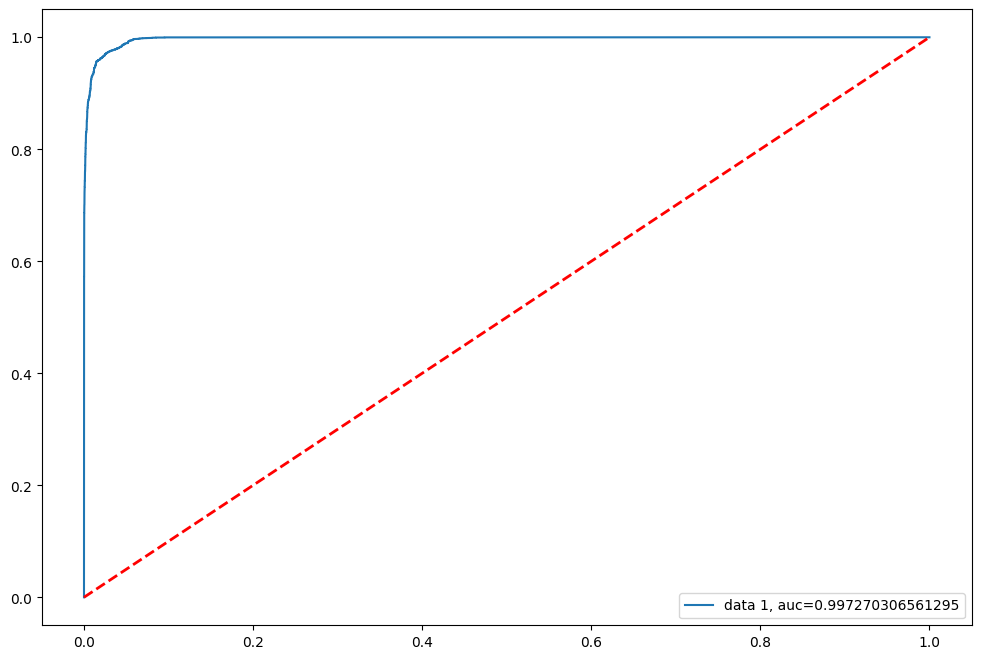

In [28]:
y_pred_proba =  rf.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

## Árvore de Decisão

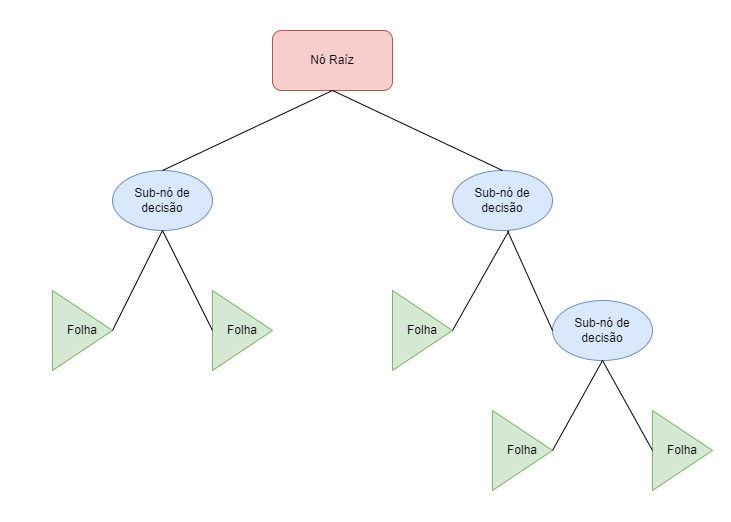

In [30]:
dt =  DecisionTreeClassifier(max_depth = 5, random_state=SEED)

In [31]:
model = dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9622849711324362
Precisão: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943


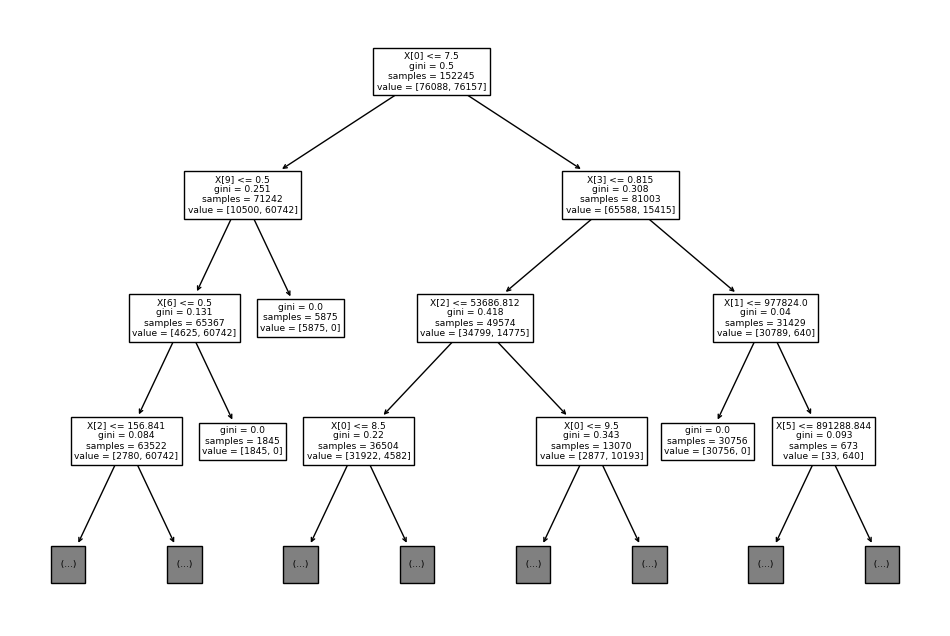

In [44]:
from sklearn import tree
tree.plot_tree(dt,max_depth = 3)
plt.show()

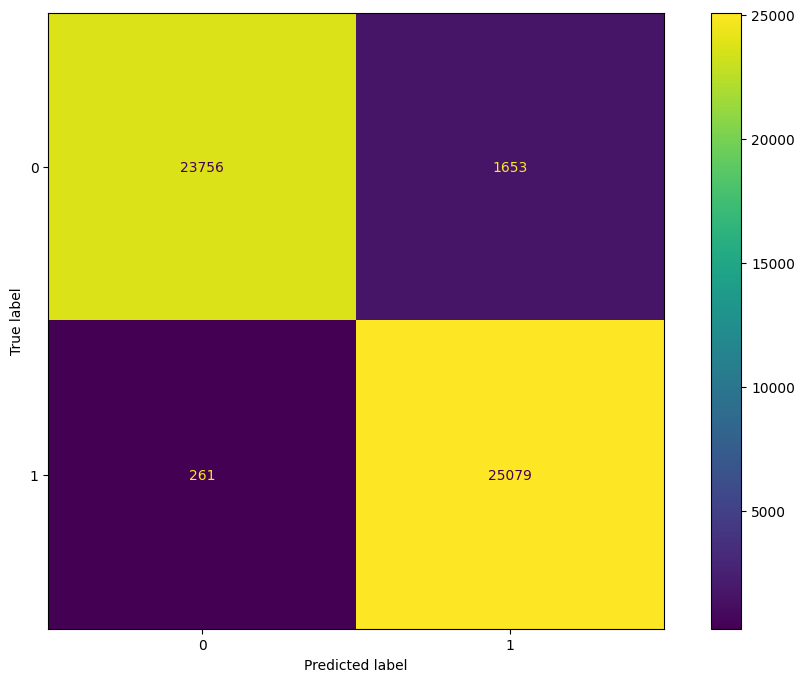

In [32]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

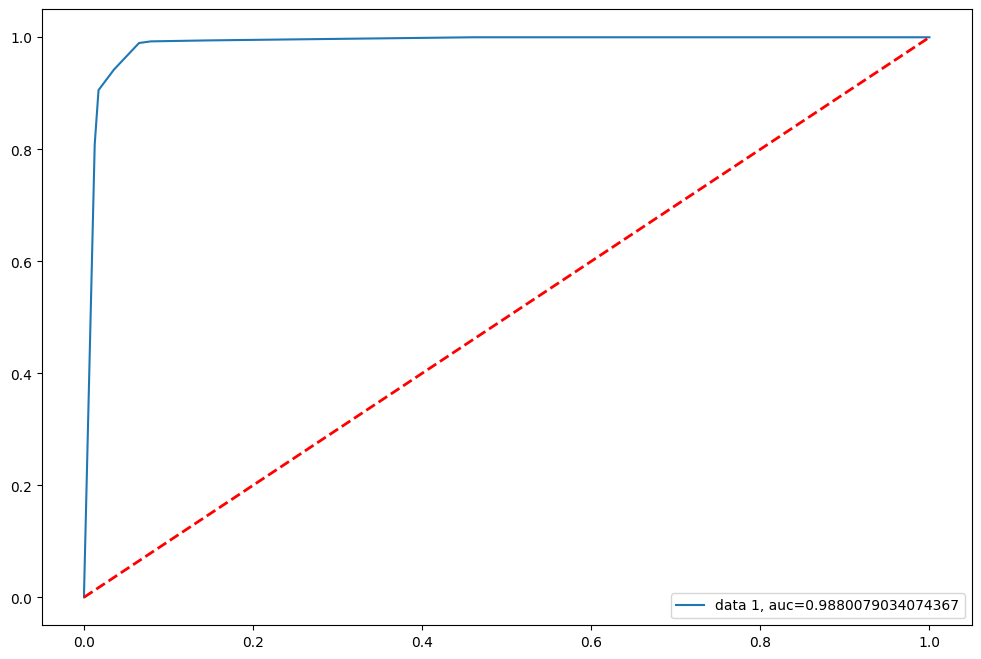

In [33]:
y_pred_proba = dt.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.rcParams['figure.figsize'] = (12., 8.)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.legend(loc=4)

# Análise de Métricas

In [46]:
classifiers = [
    LogisticRegression(max_iter=1000, random_state=SEED),
    DecisionTreeClassifier(max_depth = 5, random_state=SEED),
    RandomForestClassifier(max_depth= 5, random_state = SEED)]

LogisticRegression
****Resultados****
Accuracy: 0.9417722516699837
Precision: 0.9241993556945234
Recall: 0.9623125493291239
F1: 0.9428709521507975


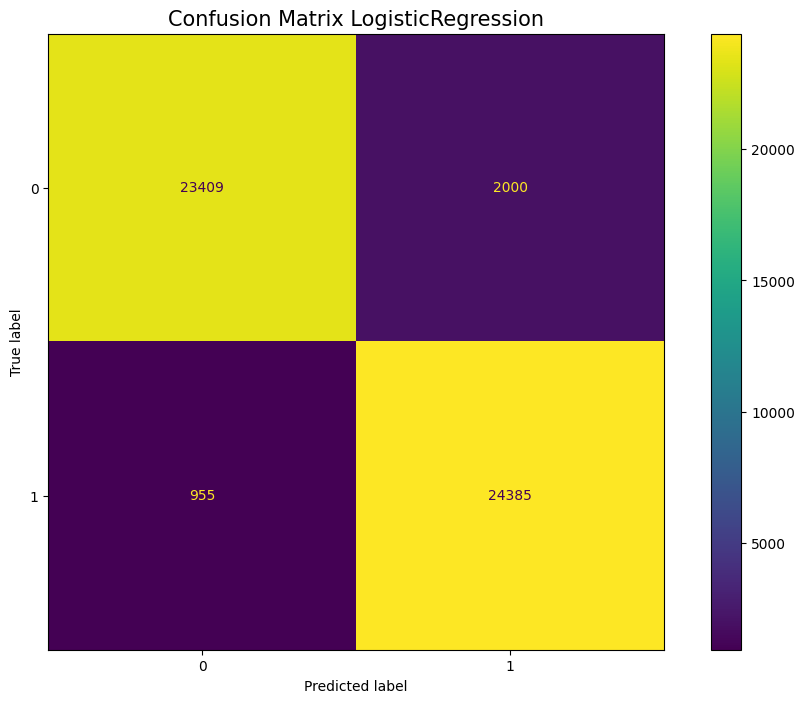

DecisionTreeClassifier
****Resultados****
Accuracy: 0.9622849711324362
Precision: 0.9381639982043992
Recall: 0.9897000789265983
F1: 0.9632432017206943


RandomForestClassifier
****Resultados****
Accuracy: 0.9723738398786183
Precision: 0.9705165500432424
Recall: 0.9742699289660616
F1: 0.9723896175509079


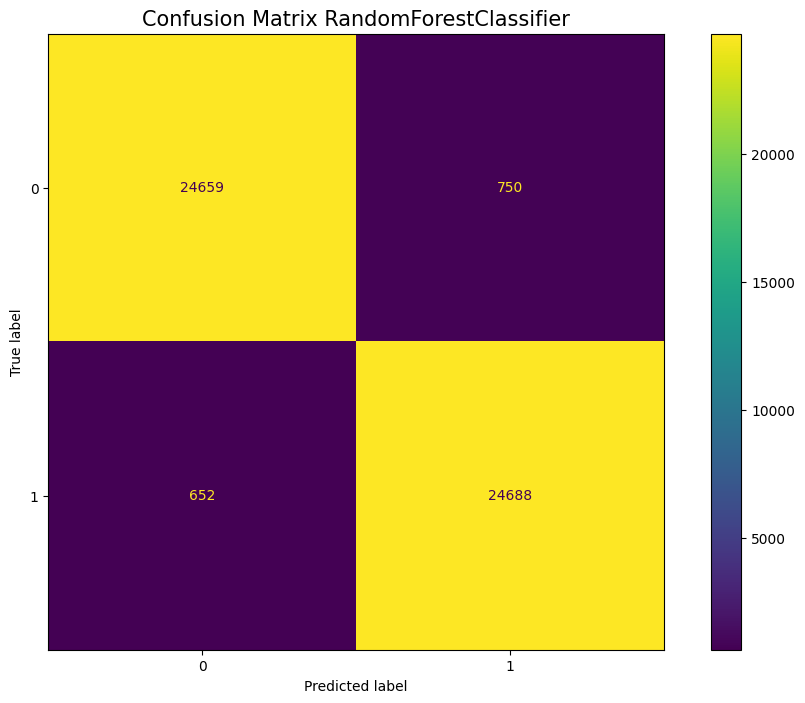

In [60]:
for clf in classifiers:
    clf.fit(x_train, y_train)
    name = clf.__class__.__name__
    print("="*90)
    print(name)
    print('****Resultados****')
    y_pred = clf.predict(x_test)
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred))
    print("Recall:", metrics.recall_score(y_test, y_pred))
    print("F1:", metrics.f1_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix {name}', fontsize=15)
    plt.show()

Levando en conta que a métrica mai importante para esse modleo seja o Recall, pois o objetivo do modelo é acertar o máximo possível as pessoas que estão cometendo fraude. É a métrica mais importante para algoritmos de detecção de fraude, uma vez que é muito mais problemático não classificar corretamente as pessoas que estão cometendo fraude, o que pode gerar um grande prejuízo.

Dentre os três modelos apresentados acima o que mais se aproxima de um recall bom é o DecisionTreeClassifier, porém ele acaba ficando para trás quando comparado as outras metricas com os outro modelos. E diante disso, o modelo que mais apresentas metricas no geral maiores é o **`Random Forest`**.

## Melhorando o modelo

In [62]:
n_estimators = np.arange(20, 200, step=20)
criterion = ["gini", "entropy"]
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(2, 10, step=1))
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [63]:
param_grid = {
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [64]:
SEED = 70
rforest = RandomForestClassifier(random_state=SEED)

In [65]:
random_cv = RandomizedSearchCV(
    rforest, param_grid, n_iter=5, cv=3, scoring="recall", n_jobs=-1, random_state = SEED
)

In [66]:
%%time
rcv = random_cv.fit(x, y)

CPU times: total: 26.3 s
Wall time: 1min 51s


In [67]:
rcv

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=70),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([ 20,  40,  60,  80, 100, 120, 140, 160, 180])},
                   random_state=70, scoring='recall')

In [70]:
pd.DataFrame(rcv.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      63.228541      4.384969         2.012558        0.139457   
1      22.834156      1.277002         1.699767        0.118034   
2      25.426548      1.931368         0.669921        0.081260   
3      46.268812      1.879940         1.227792        0.131503   
4      25.956855      5.396290         1.428748        0.557517   

  param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                120                       4                      2   
1                120                       4                      2   
2                 40                       8                      1   
3                100                       8                      4   
4                160                       6                      2   

  param_max_features param_max_depth param_criterion param_bootstrap  \
0               auto               9            gini           False   
1               auto               2            gini           False   
2               sqrt               7         entropy           False   
3               log2               9         entropy            True   
4               log2               2            gini           False   

                                              params  split0_test_score  \
0  {'n_estimators': 120, 'min_samples_split': 4, ...           0.991665   
1  {'n_estimators': 120, 'min_samples_split': 4, ...           0.914223   
2  {'n_estimators': 40, 'min_samples_split': 8, '...           0.980285   
3  {'n_estimators': 100, 'min_samples_split': 8, ...           0.993497   
4  {'n_estimators': 160, 'min_samples_split': 6, ...           0.914223   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0           0.999438           0.992817         0.994640        0.003425   
1           0.936009           0.862704         0.904312        0.030736   
2           1.000000           0.973812         0.984699        0.011138   
3           0.999025           0.992226         0.994916        0.002951   
4           0.943487           0.876537         0.911416        0.027404   

   rank_test_score  
0                2  
1                5  
2                3  
3                1  
4                4

In [71]:
rcv.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 9,
 'criterion': 'entropy',
 'bootstrap': True}

## Resultados Finais

In [72]:
rfn = RandomForestClassifier(**rcv.best_params_, random_state = SEED)

model = rfn.fit(x_train, y_train)
y_pred = rfn.predict(x_test)

print("Acurácia:",metrics.accuracy_score(y_test, y_pred))
print("Precisão:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred)) 
print("F1:",metrics.f1_score(y_test, y_pred))

Acurácia: 0.9915860411042582
Precisão: 0.9906258615936036
Recall: 0.9925414364640884
F1: 0.9915827238857459


In [73]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Conclusão

**Inserir as soluções para cada hipótese aqui!** (dê um duplo clique na célula)